# Exercise 7: Multiple Agents

Extension of https://oist.github.io/BrainComputation/Multiple.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Testing an Evolutionary Algorithm

In [ ]:
# two-link arm kinematics
def forward_kinematics(theta1, theta2, l1=0.3, l2=0.25):
    """compute end-effector position from joint angles"""
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return np.array([x, y])

# gaussian basis functions for acceleration control
def gaussian_basis_functions(t, m=10, duration=1.0):
    """generate m gaussian basis functions over duration"""
    centers = np.linspace(0, duration, m)
    sigma = duration / (m * 2)  # overlap for smooth control
    # compute basis function values at time t
    basis = np.exp(-0.5 * ((t - centers) / sigma)**2)
    return basis

# integration system: acceleration -> velocity -> position
def integrate_motion(weights, dt=0.01, n_steps=100, initial_angles=None):
    """integrate joint accelerations to get trajectory"""
    if initial_angles is None:
        initial_angles = np.array([0.5, 0.8])  # default start position
    # initialize trajectory arrays
    theta = np.zeros((n_steps, 2))
    theta_dot = np.zeros((n_steps, 2))
    theta_ddot = np.zeros((n_steps, 2))
    # set initial conditions
    theta[0] = initial_angles
    # integrate over time
    for i in range(1, n_steps):
        t = i * dt
        # compute acceleration from weighted basis functions
        basis = gaussian_basis_functions(t)
        theta_ddot[i] = weights @ basis  # shape: (2, 10) @ (10,) -> (2,)
        # euler integration
        theta_dot[i] = theta_dot[i-1] + theta_ddot[i] * dt
        theta[i] = theta[i-1] + theta_dot[i] * dt
    return theta, theta_dot, theta_ddot

#### CMA-ES Mathematical Formulation

The Covariance Matrix Adaptation Evolution Strategy (CMA-ES) maintains a multivariate normal distribution N(m, σ²C) where:
- **m**: mean vector (search center)
- **σ**: step size (global scaling)
- **C**: covariance matrix (search direction and scaling)

**Key update equations:**
- Mean update: $m^{(g+1)} = \sum_{i=1}^{\mu} w_i x_{i:\lambda}^{(g)}$
- Step size adaptation: $\sigma^{(g+1)} = \sigma^{(g)} \exp\left(\frac{c_\sigma}{d_\sigma}\left(\frac{\|p_\sigma^{(g+1)}\|}{\mathbb{E}[\|\mathcal{N}(0,I)\|]} - 1\right)\right)$
- Covariance update: $C^{(g+1)} = (1-c_1-c_\mu)C^{(g)} + c_1 p_c^{(g+1)}(p_c^{(g+1)})^T + c_\mu \sum_{i=1}^{\mu} w_i y_{i:\lambda}^{(g)}(y_{i:\lambda}^{(g)})^T$

**Evolution paths:**
- $p_\sigma^{(g+1)} = (1-c_\sigma)p_\sigma^{(g)} + \sqrt{c_\sigma(2-c_\sigma)\mu_{eff}} B^{(g)}y_w^{(g)}$
- $p_c^{(g+1)} = (1-c_c)p_c^{(g)} + h_\sigma \sqrt{c_c(2-c_c)\mu_{eff}} y_w^{(g)}$

where $y_w^{(g)} = \sum_{i=1}^{\mu} w_i y_{i:\lambda}^{(g)}$ is the weighted average step.

In [ ]:
# cma-es optimization algorithm
class cma_es:
    def __init__(self, dimension, sigma=0.5, population_size=None):
        """covariance matrix adaptation evolution strategy"""
        self.n = dimension
        self.sigma = sigma
        self.lambda_ = population_size or 4 + int(3 * np.log(self.n))
        self.mu = self.lambda_ // 2
        # selection weights
        self.weights = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu + 1))
        self.weights /= np.sum(self.weights)
        self.mu_eff = 1 / np.sum(self.weights**2)
        # adaptation parameters
        self.c_sigma = (self.mu_eff + 2) / (self.n + self.mu_eff + 5)
        self.c_c = (4 + self.mu_eff / self.n) / (self.n + 4 + 2 * self.mu_eff / self.n)
        self.c_1 = 2 / ((self.n + 1.3)**2 + self.mu_eff)
        self.c_mu = min(1 - self.c_1, 2 * (self.mu_eff - 2 + 1 / self.mu_eff) / ((self.n + 2)**2 + self.mu_eff))
        self.damps = 1 + 2 * max(0, np.sqrt((self.mu_eff - 1) / (self.n + 1)) - 1) + self.c_sigma        
        # state variables
        self.mean = np.zeros(self.n)
        self.C = np.eye(self.n)
        self.pc = np.zeros(self.n)
        self.ps = np.zeros(self.n)
        self.B = np.eye(self.n)
        self.D = np.ones(self.n)
        self.eigeneval = 0

    def ask(self):
        """generate new population"""
        if self.eigeneval == 0 or self.eigeneval % (self.lambda_ // (self.c_1 + self.c_mu) / self.n / 10) == 0:
            self.D, self.B = np.linalg.eigh(self.C)
            self.D = np.sqrt(np.maximum(self.D, 0))
        self.eigeneval += 1
        # sample from multivariate normal
        z = np.random.randn(self.lambda_, self.n)
        y = z @ (self.B * self.D).T
        x = self.mean + self.sigma * y        
        return x, z, y

    def tell(self, x, fitness):
        """update distribution based on fitness"""
        # sort by fitness (assuming minimization)
        idx = np.argsort(fitness)
        x_sorted = x[idx]
        # update mean
        self.mean = np.sum(self.weights[:, np.newaxis] * x_sorted[:self.mu], axis=0)
        # update evolution paths
        y_w = np.sum(self.weights[:, np.newaxis] * (x_sorted[:self.mu] - self.mean) / self.sigma, axis=0)
        self.ps = (1 - self.c_sigma) * self.ps + np.sqrt(self.c_sigma * (2 - self.c_sigma) * self.mu_eff) * (self.B @ y_w)
        hsig = np.linalg.norm(self.ps) / np.sqrt(1 - (1 - self.c_sigma)**(2 * self.eigeneval / self.lambda_)) / np.sqrt(self.n) < 1.4 + 2 / (self.n + 1)
        self.pc = (1 - self.c_c) * self.pc + hsig * np.sqrt(self.c_c * (2 - self.c_c) * self.mu_eff) * y_w
        # update covariance matrix
        artmp = (x_sorted[:self.mu] - self.mean) / self.sigma
        self.C = (1 - self.c_1 - self.c_mu) * self.C + self.c_1 * np.outer(self.pc, self.pc) + self.c_mu * (self.weights * artmp.T) @ artmp
        # update sigma
        self.sigma *= np.exp((self.c_sigma / self.damps) * (np.linalg.norm(self.ps) / np.sqrt(self.n) - 1))
        return idx[0]  # return best index

In [ ]:
# reaching task objective function
def reaching_objective(weights, target_pos, initial_angles=None):
    """objective function for reaching task - returns error to minimize"""
    # reshape weights to (2, 10) for two joints, 10 basis functions each
    w = weights.reshape(2, 10)
    # simulate arm trajectory
    theta, _, _ = integrate_motion(w, initial_angles=initial_angles)
    # compute end-effector trajectory
    end_effector_traj = np.array([forward_kinematics(theta[i, 0], theta[i, 1]) for i in range(len(theta))])
    # final position error
    final_pos = end_effector_traj[-1]
    position_error = np.linalg.norm(final_pos - target_pos)
    # add smoothness penalty
    accelerations = np.array([gaussian_basis_functions(i * 0.01) @ w.T for i in range(100)])
    smoothness_penalty = 0.001 * np.sum(np.linalg.norm(np.diff(accelerations, axis=0), axis=1))
    return position_error + smoothness_penalty

# arm reaching optimization
def optimize_reaching(target_pos, initial_angles=None, max_generations=100):
    """optimize basis function weights for reaching target position"""
    n_params = 20  # 2 joints * 10 basis functions
    # initialize cma-es
    optimizer = cma_es(dimension=n_params, sigma=0.3)
    best_fitness = np.inf
    best_weights = None
    fitness_history = []
    for gen in range(max_generations):
        # generate population
        population, _, _ = optimizer.ask()
        # evaluate fitness for each individual
        fitness = np.array([reaching_objective(ind, target_pos, initial_angles) for ind in population])
        # update optimizer
        best_idx = optimizer.tell(population, fitness)
        # track best solution
        if fitness[best_idx] < best_fitness:
            best_fitness = fitness[best_idx]
            best_weights = population[best_idx].copy()
        fitness_history.append(best_fitness)
        # convergence check
        if best_fitness < 0.001:
            print(f"converged at generation {gen} with error {best_fitness:.6f}")
            break
    return best_weights.reshape(2, 10), fitness_history

In [ ]:
# test the complete system
np.random.seed(42)  # for reproducibility

# define target position
target = np.array([0.4, 0.3])
initial_pos = np.array([0.5, 0.8])  # initial joint angles
print(f"target position: {target}")
print(f"initial joint angles: {initial_pos}")

# optimize reaching movement
optimal_weights, history = optimize_reaching(target, initial_pos, max_generations=100)
print(f"\noptimization complete!")
print(f"final error: {history[-1]:.6f}")

# simulate optimal trajectory
theta_opt, theta_dot_opt, theta_ddot_opt = integrate_motion(optimal_weights, initial_angles=initial_pos)
end_effector_opt = np.array([forward_kinematics(theta_opt[i, 0], theta_opt[i, 1]) for i in range(len(theta_opt))])
print(f"final end-effector position: {end_effector_opt[-1]}")
print(f"target position: {target}")
print(f"final error: {np.linalg.norm(end_effector_opt[-1] - target):.6f}")

target position: [0.4 0.3]
initial joint angles: [0.5 0.8]

optimization complete!
final error: 0.003484
final end-effector position: [0.4 0.3]
target position: [0.4 0.3]
final error: 0.000000


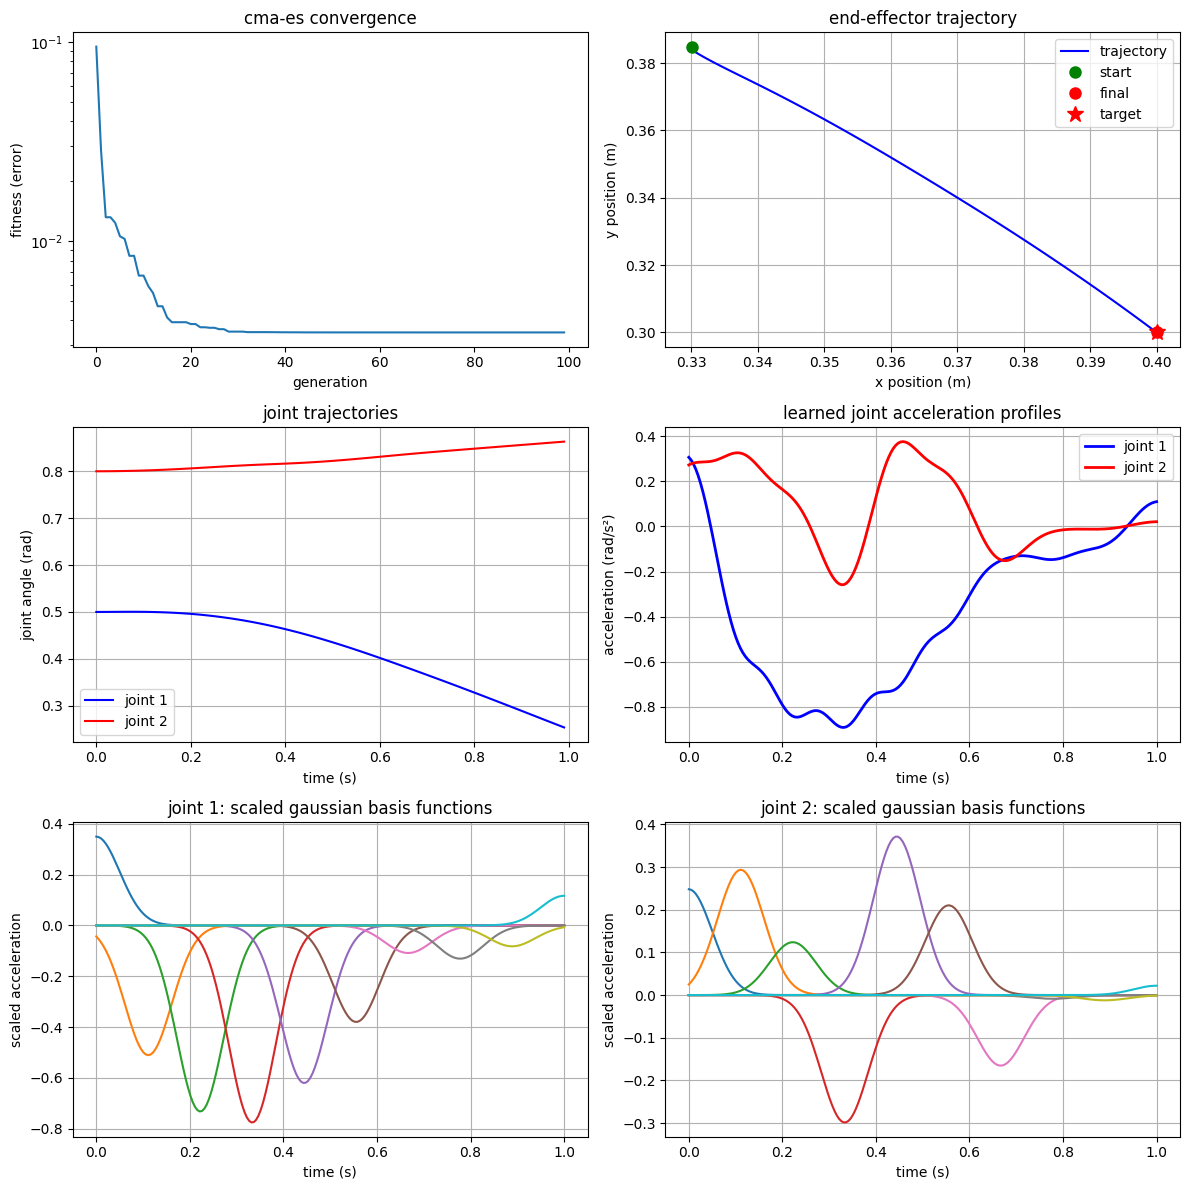

In [17]:
# visualization
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# plot 1: convergence history
axes[0, 0].plot(history)
axes[0, 0].set_xlabel('generation')
axes[0, 0].set_ylabel('fitness (error)')
axes[0, 0].set_title('cma-es convergence')
axes[0, 0].set_yscale('log')

# plot 2: end-effector trajectory
axes[0, 1].plot(end_effector_opt[:, 0], end_effector_opt[:, 1], 'b-', label='trajectory')
axes[0, 1].plot(end_effector_opt[0, 0], end_effector_opt[0, 1], 'go', markersize=8, label='start')
axes[0, 1].plot(end_effector_opt[-1, 0], end_effector_opt[-1, 1], 'ro', markersize=8, label='final')
axes[0, 1].plot(target[0], target[1], 'r*', markersize=12, label='target')
axes[0, 1].set_xlabel('x position (m)')
axes[0, 1].set_ylabel('y position (m)')
axes[0, 1].set_title('end-effector trajectory')
axes[0, 1].legend()
axes[0, 1].grid(True)

# plot 3: joint angles over time
time = np.arange(100) * 0.01
axes[1, 0].plot(time, theta_opt[:, 0], 'b-', label='joint 1')
axes[1, 0].plot(time, theta_opt[:, 1], 'r-', label='joint 2')
axes[1, 0].set_xlabel('time (s)')
axes[1, 0].set_ylabel('joint angle (rad)')
axes[1, 0].set_title('joint trajectories')
axes[1, 0].legend()
axes[1, 0].grid(True)

# plot 4: joint acceleration profiles
time_fine = np.linspace(0, 1, 200)
basis_functions = np.array([gaussian_basis_functions(t) for t in time_fine])
total_accel_1 = np.sum([optimal_weights[0, i] * basis_functions[:, i] for i in range(10)], axis=0)
total_accel_2 = np.sum([optimal_weights[1, i] * basis_functions[:, i] for i in range(10)], axis=0)

axes[1, 1].plot(time_fine, total_accel_1, 'b-', linewidth=2, label='joint 1')
axes[1, 1].plot(time_fine, total_accel_2, 'r-', linewidth=2, label='joint 2')
axes[1, 1].set_xlabel('time (s)')
axes[1, 1].set_ylabel('acceleration (rad/s²)')
axes[1, 1].set_title('learned joint acceleration profiles')
axes[1, 1].legend()
axes[1, 1].grid(True)

# plot 5: joint 1 scaled basis functions
for i in range(10):
    scaled_basis = optimal_weights[0, i] * basis_functions[:, i]
    axes[2, 0].plot(time_fine, scaled_basis, label=f'w₁₍{i+1}₎ × φ{i+1}')
axes[2, 0].set_xlabel('time (s)')
axes[2, 0].set_ylabel('scaled acceleration')
axes[2, 0].set_title('joint 1: scaled gaussian basis functions')
axes[2, 0].grid(True)

# plot 6: joint 2 scaled basis functions  
for i in range(10):
    scaled_basis = optimal_weights[1, i] * basis_functions[:, i]
    axes[2, 1].plot(time_fine, scaled_basis, label=f'w₂₍{i+1}₎ × φ{i+1}')
axes[2, 1].set_xlabel('time (s)')
axes[2, 1].set_ylabel('scaled acceleration')
axes[2, 1].set_title('joint 2: scaled gaussian basis functions')
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

### 2.  Nash Equilibria and ESSs

Volunteer's dilemma: two agents could “Contribute” (C) to produce a public good of value $b > 0$ for both; contributors pay cost $c > 0$. If at least one contributes, both enjoy $b$, with one agent enjoying the "Free-ride" (F). If nobody contributes, both get $0$.

The row-payoff matrix (rows & cols: C/F):
$$A = B^\top = \begin{bmatrix}b-c & b-c \\ b & 0\end{bmatrix}$$

In [ ]:
class Game:
    def __init__(self, paymat):
        """setup a game with payoff matrices"""
        self.paymat = paymat  # list of payoff matrices
        self.N = len(paymat)  # number of players

    def payoff(self, X):
        """payoffs for a mixed strategy profile X"""
        pay0 = X[0]@self.paymat[0]@X[1]
        pay1 = X[0]@self.paymat[1]@X[1]
        return [pay0, pay1]

    def best_reply(self, X):
        """best pure strategies for a mixed strategy profile X"""
        pay0 = self.paymat[0]@X[1]  # payoffs for pure strategies
        pay1 = X[0]@self.paymat[1]
        return [np.argmax(pay0), np.argmax(pay1)]
        # this misses mixed strategies of two best pure strategies

    def plot_payoff(self):
        """visualize payoff for mixed strategies for a two-player game"""
        # xg, yg = np.mgrid[0:1.01:0.05, 0:1.01:0.05]
        p = np.linspace(0., 1., 21) # prob of taking a strategy
        x = np.array([1-p, p])   # mixed strategies from [1,0] to [0,1]
        # Payoff surfaces
        pay0 = x.T@self.paymat[0]@x
        pay1 = x.T@self.paymat[1]@x
        # best reply lines
        best_reps = np.zeros((len(p), 2))
        for j, xj in enumerate(x.T):
            best_reps[j] = self.best_reply([xj, xj])
        #print(best_reps)
        plt.subplot(1,2,1)
        plt.imshow(pay0, extent=(0,1, 1,0))
        plt.plot(p, best_reps[:,0], c="r", lw=4)  # best replies for player 0
        plt.title("P1 payoff"); plt.ylabel("P1 strategy");  plt.xlabel("P2 strategy");
        plt.subplot(1,2,2)
        plt.imshow(pay1, extent=(0,1, 1,0))
        plt.plot(best_reps[:,1], p, c="r", lw=4)  # best replies for player 1
        plt.title("P2 payoff"); plt.xlabel("P2 strategy");

Best replies:
* Against $C$, row prefers $F$ since $b > b-c$
* Against $F$, row prefers $C$ if $b>c$

Thus, for $b>c$ there are two asymmetric pure Nash equilibria $(C,F)$ and $(F,C)$. In the mixed strategy case, let the column player select $C$ with probability $q$. Then, $q^* = 1-\frac{c}{b}$. By symmetry, $p^*$ for the row player will also be identical.

In [ ]:
# game sim: define payoff matrices
b = 3.0  # benefit from public good
c = 1.0  # cost of contributing
# payoff matrices A (row player) and B (column player)
A = np.array([[b-c, b-c],
              [b, 0]])    # row player payoffs: C vs F
B = A.T                   # column player payoffs (symmetric game)
vd_game = Game([A, B])

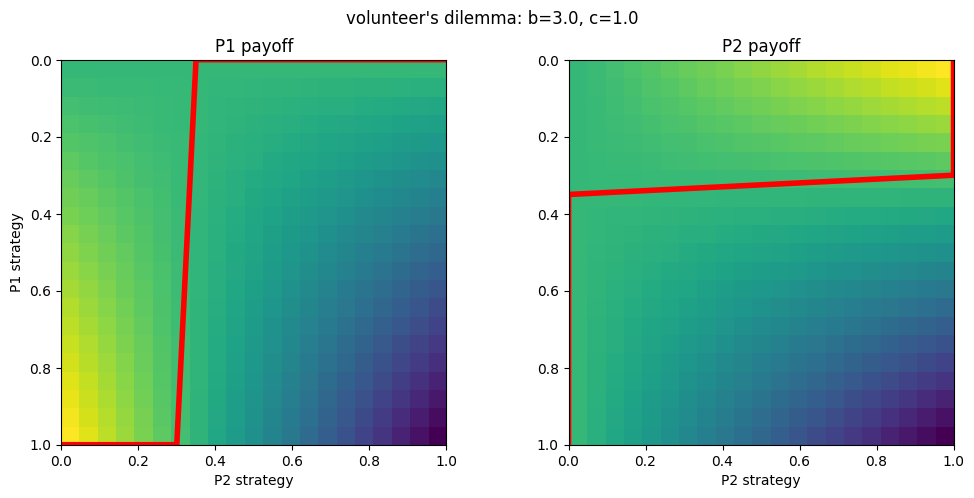

In [15]:
# plot payoffs and best replies using built-in method
plt.figure(figsize=(12, 5))
vd_game.plot_payoff()
plt.suptitle(f'volunteer\'s dilemma: b={b}, c={c}')
plt.show()

ESS conditions can be tested to hold true at the mixed Nash equilibrium above $\mathbf{x}^* = \begin{bmatrix}p^*, 1-p^*\end{bmatrix}$:
* $u(\mathbf{x}^*, C) = b - \frac{c^2}{b} > u(C, C) = b-c$
* $u(\mathbf{x}^*, F) = (1 - \frac{c}{b})(b-c) > u(F, F) = 0$

Thus, the equilibrium is also an evolutionarily stable strategy.

### 3. Replicator Dynamics

Testing whether deviations from the Nash equilibrium are damped or amplified by selection or evolution of choices in the game (i.e. replicator dynamics).

In [ ]:
from scipy.integrate import odeint

class RepGame(Game):
    def repeq(self, x, t=0):
        """replicator equation for odeint"""
        dx = np.ravel(self.paymat[0]@x - x@self.paymat[0]@x)*x
        return dx

    def replicator(self, x0, tt):
        """replicator dynamimcs; x0: initial population, tt: array of time points"""
        xt = odeint(self.repeq, x0, tt)
        return xt

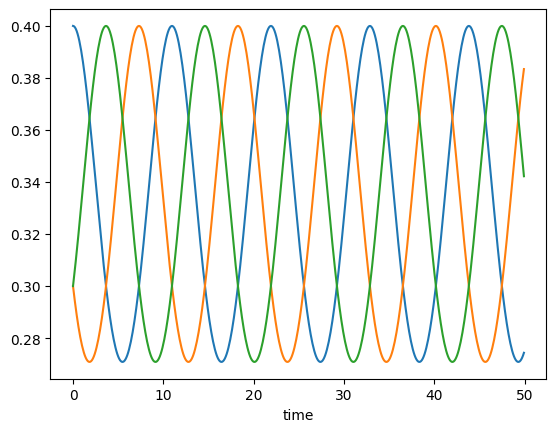

In [ ]:
# rock-scissors-paper game
a = 0 # zero-sum game (win = lose)
A = np.array([[0, 1+a, -1], [-1, 0, 1+a], [1+a, -1, 0]])
rsp = RepGame([A, A.T])
tt = np.arange(0, 50, 0.1)
xt = rsp.replicator(np.array([0.4, 0.3, 0.3]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

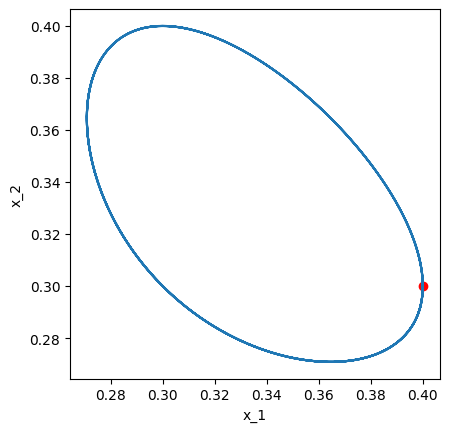

In [13]:
plt.plot(xt[0,0], xt[0,1], "ro")  # initial point
plt.plot(xt[:,0], xt[:,1])
plt.xlabel("x_1"); plt.ylabel("x_2"); plt.axis("square");

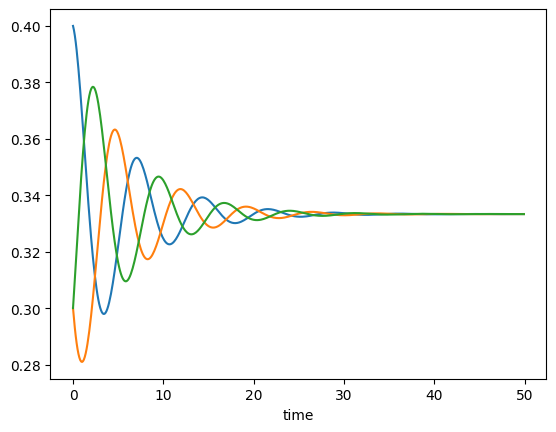

In [ ]:
# rock-scissors-paper game
a = 1 # delta importance of winning versus not losing
A = np.array([[0, 1+a, -1], [-1, 0, 1+a], [1+a, -1, 0]])
rsp = RepGame([A, A.T])
tt = np.arange(0, 50, 0.1)
xt = rsp.replicator(np.array([0.4, 0.3, 0.3]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

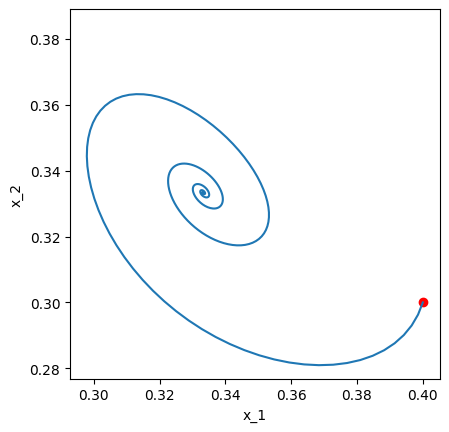

In [9]:
plt.plot(xt[0,0], xt[0,1], "ro")  # initial point
plt.plot(xt[:,0], xt[:,1])
plt.xlabel("x_1"); plt.ylabel("x_2"); plt.axis("square");

When wins pay more than losses (here, a > 0), the system converges to the Nash equilibrium of $\begin{bmatrix}\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\end{bmatrix}$, since winning will eventually compensate for the loss in losing. Note that this could also reflect the subjective state of players, with the parameter (a) reflecting the outcome that receives more care, while the payoff could objectively still be symmetric. Setting a > 0 would imply that the players care more about winning than losing.

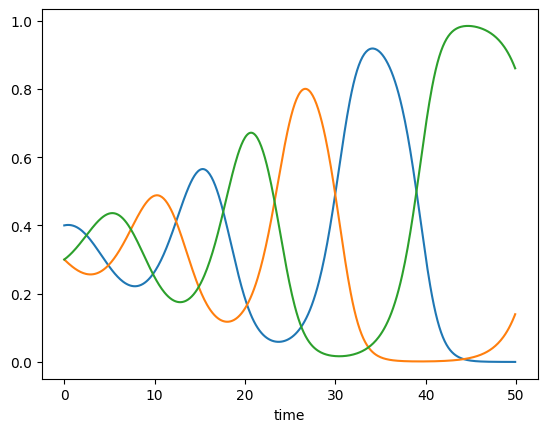

In [ ]:
# rock-scissors-paper game
a = -0.5 # delta importance of winning versus not losing
A = np.array([[0, 1+a, -1], [-1, 0, 1+a], [1+a, -1, 0]])
rsp = RepGame([A, A.T])
tt = np.arange(0, 50, 0.1)
xt = rsp.replicator(np.array([0.4, 0.3, 0.3]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

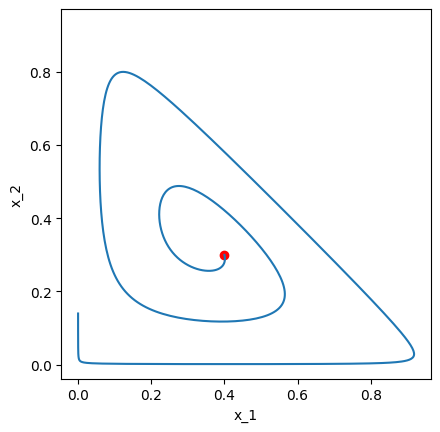

In [11]:
plt.plot(xt[0,0], xt[0,1], "ro")  # initial point
plt.plot(xt[:,0], xt[:,1])
plt.xlabel("x_1"); plt.ylabel("x_2"); plt.axis("square");

With caring about losses more than wins (here a < 0), we get to evolution through states/mixed strategy pairs which inflict more loss than focussing on winning (exaggerating the asymmetry of outcomes) as a best reply, causing well-phased oscillatory behavior, unlike in the previous case where both must struggle to win at the same time and thereby converging to the Nash equilibrium.